In [95]:
import json
import pandas as pd
import numpy as np
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay
)
from matplotlib import pyplot as plt
import os
import torch

In [96]:
from sklearn.metrics import classification_report

def fbeta_score(precision, recall, beta):
    beta_squared = beta ** 2
    numerator = (1 + beta_squared) * precision * recall
    denominator = beta_squared * precision + recall
    fbeta = numerator / denominator
    return fbeta

def classification_report_fbeta(y_true, y_pred, beta=0.5, target_names=['0', '1', '2']):
    report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
    
    fbeta_scores = {}
    for class_name, metrics in report.items():
        if class_name == 'accuracy':
            continue
        precision = metrics['precision']
        recall = metrics['recall']
        fbeta = fbeta_score(precision, recall, beta)
        fbeta_scores[class_name] = fbeta
    
    weighted_precision = report['weighted avg']['precision']
    weighted_recall = report['weighted avg']['recall']
    weighted_fbeta = fbeta_score(weighted_precision, weighted_recall, beta)

    # Print the F0.5 score for each class
    print("F0.5 scores per class:")
    for class_name, fbeta in fbeta_scores.items():
        print(f"{class_name}: {fbeta:.2f}")
    
    return report, weighted_fbeta, fbeta_scores

y_true = [0, 1, 0, 1, 1, 2]
y_pred = [0, 0, 1, 1, 1, 2]
report, weighted_fbeta, fbeta_scores = classification_report_fbeta(y_true, y_pred, beta=0.5)


F0.5 scores per class:
0: 0.50
1: 0.67
2: 1.00
macro avg: 0.72
weighted avg: 0.67


(2965504,) (2965504,) (2965504,)


F0.5 scores per class:
GREEN: 0.93
YELLOW: 0.26
RED: 0.74
macro avg: 0.66
weighted avg: 0.85
({'GREEN': {'precision': 0.9531568329804658, 'recall': 0.847668149884984, 'f1-score': 0.8973228346456692, 'support': 450372.0}, 'YELLOW': {'precision': 0.22398023251103819, 'recall': 0.5897523411335566, 'f1-score': 0.3246591589652055, 'support': 46879.0}, 'RED': {'precision': 0.8095144870790916, 'recall': 0.5638123806926643, 'f1-score': 0.6646841343835396, 'support': 88008.0}, 'accuracy': 0.7843245469100005, 'macro avg': {'precision': 0.6622171841901986, 'recall': 0.6670776239037348, 'f1-score': 0.6288887093314713, 'support': 585259.0}, 'weighted avg': {'precision': 0.873149954946135, 'recall': 0.7843245469100005, 'f1-score': 0.8164697983234701, 'support': 585259.0}}, 0.8538109937459512, {'GREEN': 0.9300096858245911, 'YELLOW': 0.25569763548820884, 'RED': 0.7446157170640351, 'macro avg': 0.6631835976268864, 'weighted avg': 0.8538109937459512})
              precision    recall  f1-score   suppor

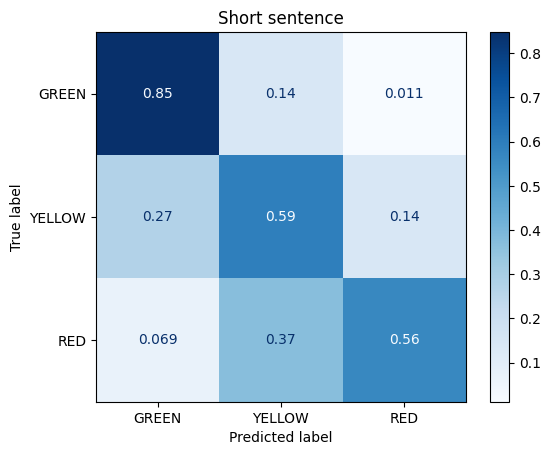

In [100]:
def convert_score_to_color(score, YELLOW_GREEN=75/50, RED_YELLOW=30/50):
    LABEL2ID = {"GREEN": 0, "YELLOW": 1, "RED":2}
    red_index = score < RED_YELLOW
    yellow_index = ((score >= RED_YELLOW).int() & (score < YELLOW_GREEN).int()).bool()
    green_index = score >= YELLOW_GREEN

    score[red_index] = LABEL2ID["RED"]
    score[yellow_index] = LABEL2ID["YELLOW"]
    score[green_index] = LABEL2ID["GREEN"]

    return score

def load_pred_and_label(pred_path, label_path):
    pred = np.load(pred_path)
    label = np.load(label_path)

    pred = np.concatenate(pred)
    label = np.concatenate(label)
    index = label != -1    
    print(index.shape, pred.shape, label.shape)
    
    return label[index], pred[index]
def cal_f1(pred_path, label_path, YELLOW_GREEN=80/50, RED_YELLOW=30/50):
    label, pred = load_pred_and_label(pred_path=pred_path, label_path=label_path)
    
    actual = convert_score_to_color(torch.from_numpy(label), YELLOW_GREEN=YELLOW_GREEN, RED_YELLOW=RED_YELLOW)
    predicted = convert_score_to_color(torch.from_numpy(pred), YELLOW_GREEN=YELLOW_GREEN, RED_YELLOW=RED_YELLOW)
    
    f_beta = classification_report_fbeta(y_true=actual, y_pred=predicted, beta=0.5, target_names=["GREEN", "YELLOW", "RED"])
    print(f_beta)
    result = classification_report(y_true=actual, y_pred=predicted)
    cfs_mtr = confusion_matrix(actual, predicted)
    print(result)
    
    cfs_mtr = cfs_mtr / cfs_mtr.sum(axis=1, keepdims=True)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cfs_mtr, display_labels = ["GREEN", "YELLOW", "RED"])
    

    return result, cm_display.plot(cmap='Blues')
    
pred_path = "/data/codes/apa/train/exps/test-short-v2/ckpts-eph=35-mse=0.15209999680519104/phn_pred.npy"
label_path = "/data/codes/apa/train/exps/test-short-v2/ckpts-eph=35-mse=0.15209999680519104/phn_label.npy"

res, cm_display = cal_f1(pred_path=pred_path, label_path=label_path, YELLOW_GREEN=80/50, RED_YELLOW=30/50)
plt.title("Short sentence")
plt.show() 

(2965504,) (2965504,) (2965504,)


F0.5 scores per class:
GREEN: 0.93
YELLOW: 0.66
macro avg: 0.80
weighted avg: 0.87
({'GREEN': {'precision': 0.9531568329804658, 'recall': 0.847668149884984, 'f1-score': 0.8973228346456692, 'support': 450372.0}, 'YELLOW': {'precision': 0.6286167454298413, 'recall': 0.8609057952211852, 'f1-score': 0.726648686869951, 'support': 134887.0}, 'accuracy': 0.8507190833460058, 'macro avg': {'precision': 0.7908867892051535, 'recall': 0.8542869725530846, 'f1-score': 0.81198576075781, 'support': 585259.0}, 'weighted avg': {'precision': 0.8783587712856589, 'recall': 0.8507190833460058, 'f1-score': 0.8579868760854023, 'support': 585259.0}}, 0.8726880800613176, {'GREEN': 0.9300096858245911, 'YELLOW': 0.6644743542940064, 'macro avg': 0.8028026528477042, 'weighted avg': 0.8726880800613176})
              precision    recall  f1-score   support

         0.0       0.95      0.85      0.90    450372
         1.0       0.63      0.86      0.73    134887

    accuracy                           0.85    58525

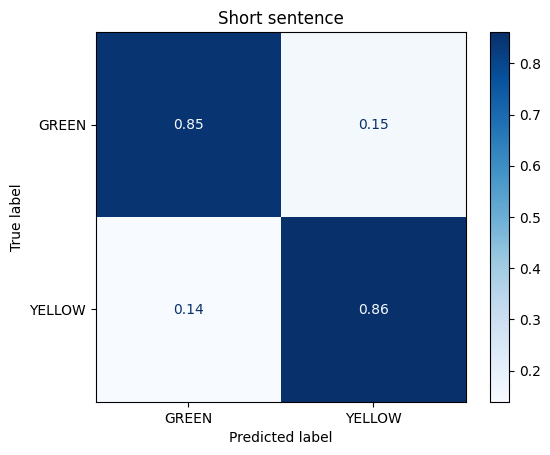

In [101]:
def convert_score_to_color(score, YELLOW_GREEN=75/50, RED_YELLOW=30/50):
    LABEL2ID = {"GREEN": 0, "YELLOW": 1, "RED":1}
    red_index = score < RED_YELLOW
    yellow_index = ((score >= RED_YELLOW).int() & (score < YELLOW_GREEN).int()).bool()
    green_index = score >= YELLOW_GREEN

    score[red_index] = LABEL2ID["RED"]
    score[yellow_index] = LABEL2ID["YELLOW"]
    score[green_index] = LABEL2ID["GREEN"]

    return score

def load_pred_and_label(pred_path, label_path):
    pred = np.load(pred_path)
    label = np.load(label_path)

    pred = np.concatenate(pred)
    label = np.concatenate(label)
    index = label != -1    
    print(index.shape, pred.shape, label.shape)
    
    return label[index], pred[index]
def cal_f1(pred_path, label_path, YELLOW_GREEN=70/50, RED_YELLOW=35/50):
    label, pred = load_pred_and_label(pred_path=pred_path, label_path=label_path)
    
    actual = convert_score_to_color(torch.from_numpy(label), YELLOW_GREEN=YELLOW_GREEN, RED_YELLOW=RED_YELLOW)
    predicted = convert_score_to_color(torch.from_numpy(pred), YELLOW_GREEN=YELLOW_GREEN, RED_YELLOW=RED_YELLOW)
    
    f_beta = classification_report_fbeta(y_true=actual, y_pred=predicted, beta=0.5, target_names=["GREEN", "YELLOW"])
    print(f_beta)
    result = classification_report(y_true=actual, y_pred=predicted)
    cfs_mtr = confusion_matrix(actual, predicted)
    print(result)
    
    cfs_mtr = cfs_mtr / cfs_mtr.sum(axis=1, keepdims=True)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cfs_mtr, display_labels = ["GREEN", "YELLOW"])
    

    return result, cm_display.plot(cmap='Blues')
    
pred_path = "/data/codes/apa/train/exps/test-short-v2/ckpts-eph=35-mse=0.15209999680519104/phn_pred.npy"
label_path = "/data/codes/apa/train/exps/test-short-v2/ckpts-eph=35-mse=0.15209999680519104/phn_label.npy"

res, cm_display = cal_f1(pred_path=pred_path, label_path=label_path, YELLOW_GREEN=80/50, RED_YELLOW=30/50)
plt.title("Short sentence")
plt.show() 

In [99]:
import numpy as np
from sklearn.metrics import classification_report

def load_pred_and_label(pred_path, label_path):
    pred = np.load(pred_path)
    label = np.load(label_path)

    pred = np.concatenate(pred)
    label = np.concatenate(label)
    index = label != -1    
    print(index.shape, pred.shape, label.shape)
    
    return label[index], pred[index]

def cal_utt_acc(pred, label, threshold=10/50):
    _temp = np.abs(pred-label)
    
    pred = _temp < threshold
    label = np.ones_like(_temp)

    print((pred == label).sum()/ label.shape)
    
    print(classification_report(y_true=label, y_pred=pred, zero_division=0))

pred_path = "/data/codes/apa/train/exps/test-short-v2/ckpts-eph=35-mse=0.15209999680519104/utt_pred.npy"
label_path = "/data/codes/apa/train/exps/test-short-v2/ckpts-eph=35-mse=0.15209999680519104/utt_label.npy"
label, pred = load_pred_and_label(pred_path=pred_path, label_path=label_path)
cal_utt_acc(pred=pred, label=label)

(92672,) (92672,) (92672,)
[0.70754921]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.71      0.83     92672

    accuracy                           0.71     92672
   macro avg       0.50      0.35      0.41     92672
weighted avg       1.00      0.71      0.83     92672

